In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scienceplots
import scipy.stats as stats
from scipy.optimize import curve_fit
from collections import namedtuple

plt.style.use('science')

In [112]:
PanelProps = namedtuple('PanelProps', ['sections', 'surface', 'total_surface', 'df', 'uU', 'uI'])
data = {
    'mono': PanelProps(1, 63, 63, pd.read_csv('mono.csv'), 0.01, 0.1),
    'poli': PanelProps(8, 7.8, 62.4, pd.read_csv('poli.csv'), 0.01, 0.02),
    'amorf': PanelProps(14, 5.5, 77, pd.read_csv('amorf.csv'), 0.01, 0.02),
}

for props in data.values():
    df = props.df
    df['P[mW]'] = (df['U[V]'] * df['I[mA]']).round(3)
    df['R[Ohm]'] = (df['U[V]'] / df['I[mA]'] * 1000).round(3)
    df['U/n[V]'] = df['U[V]'] / props.sections
    df['I[mA]'] *= -1
    df['j=I/s[mA/cm2]'] = df['I[mA]'] /props.surface

In [113]:
def fit_exp(x, a, b, c):
    return a*np.e ** (b*x) + c

mono
poli
amorf


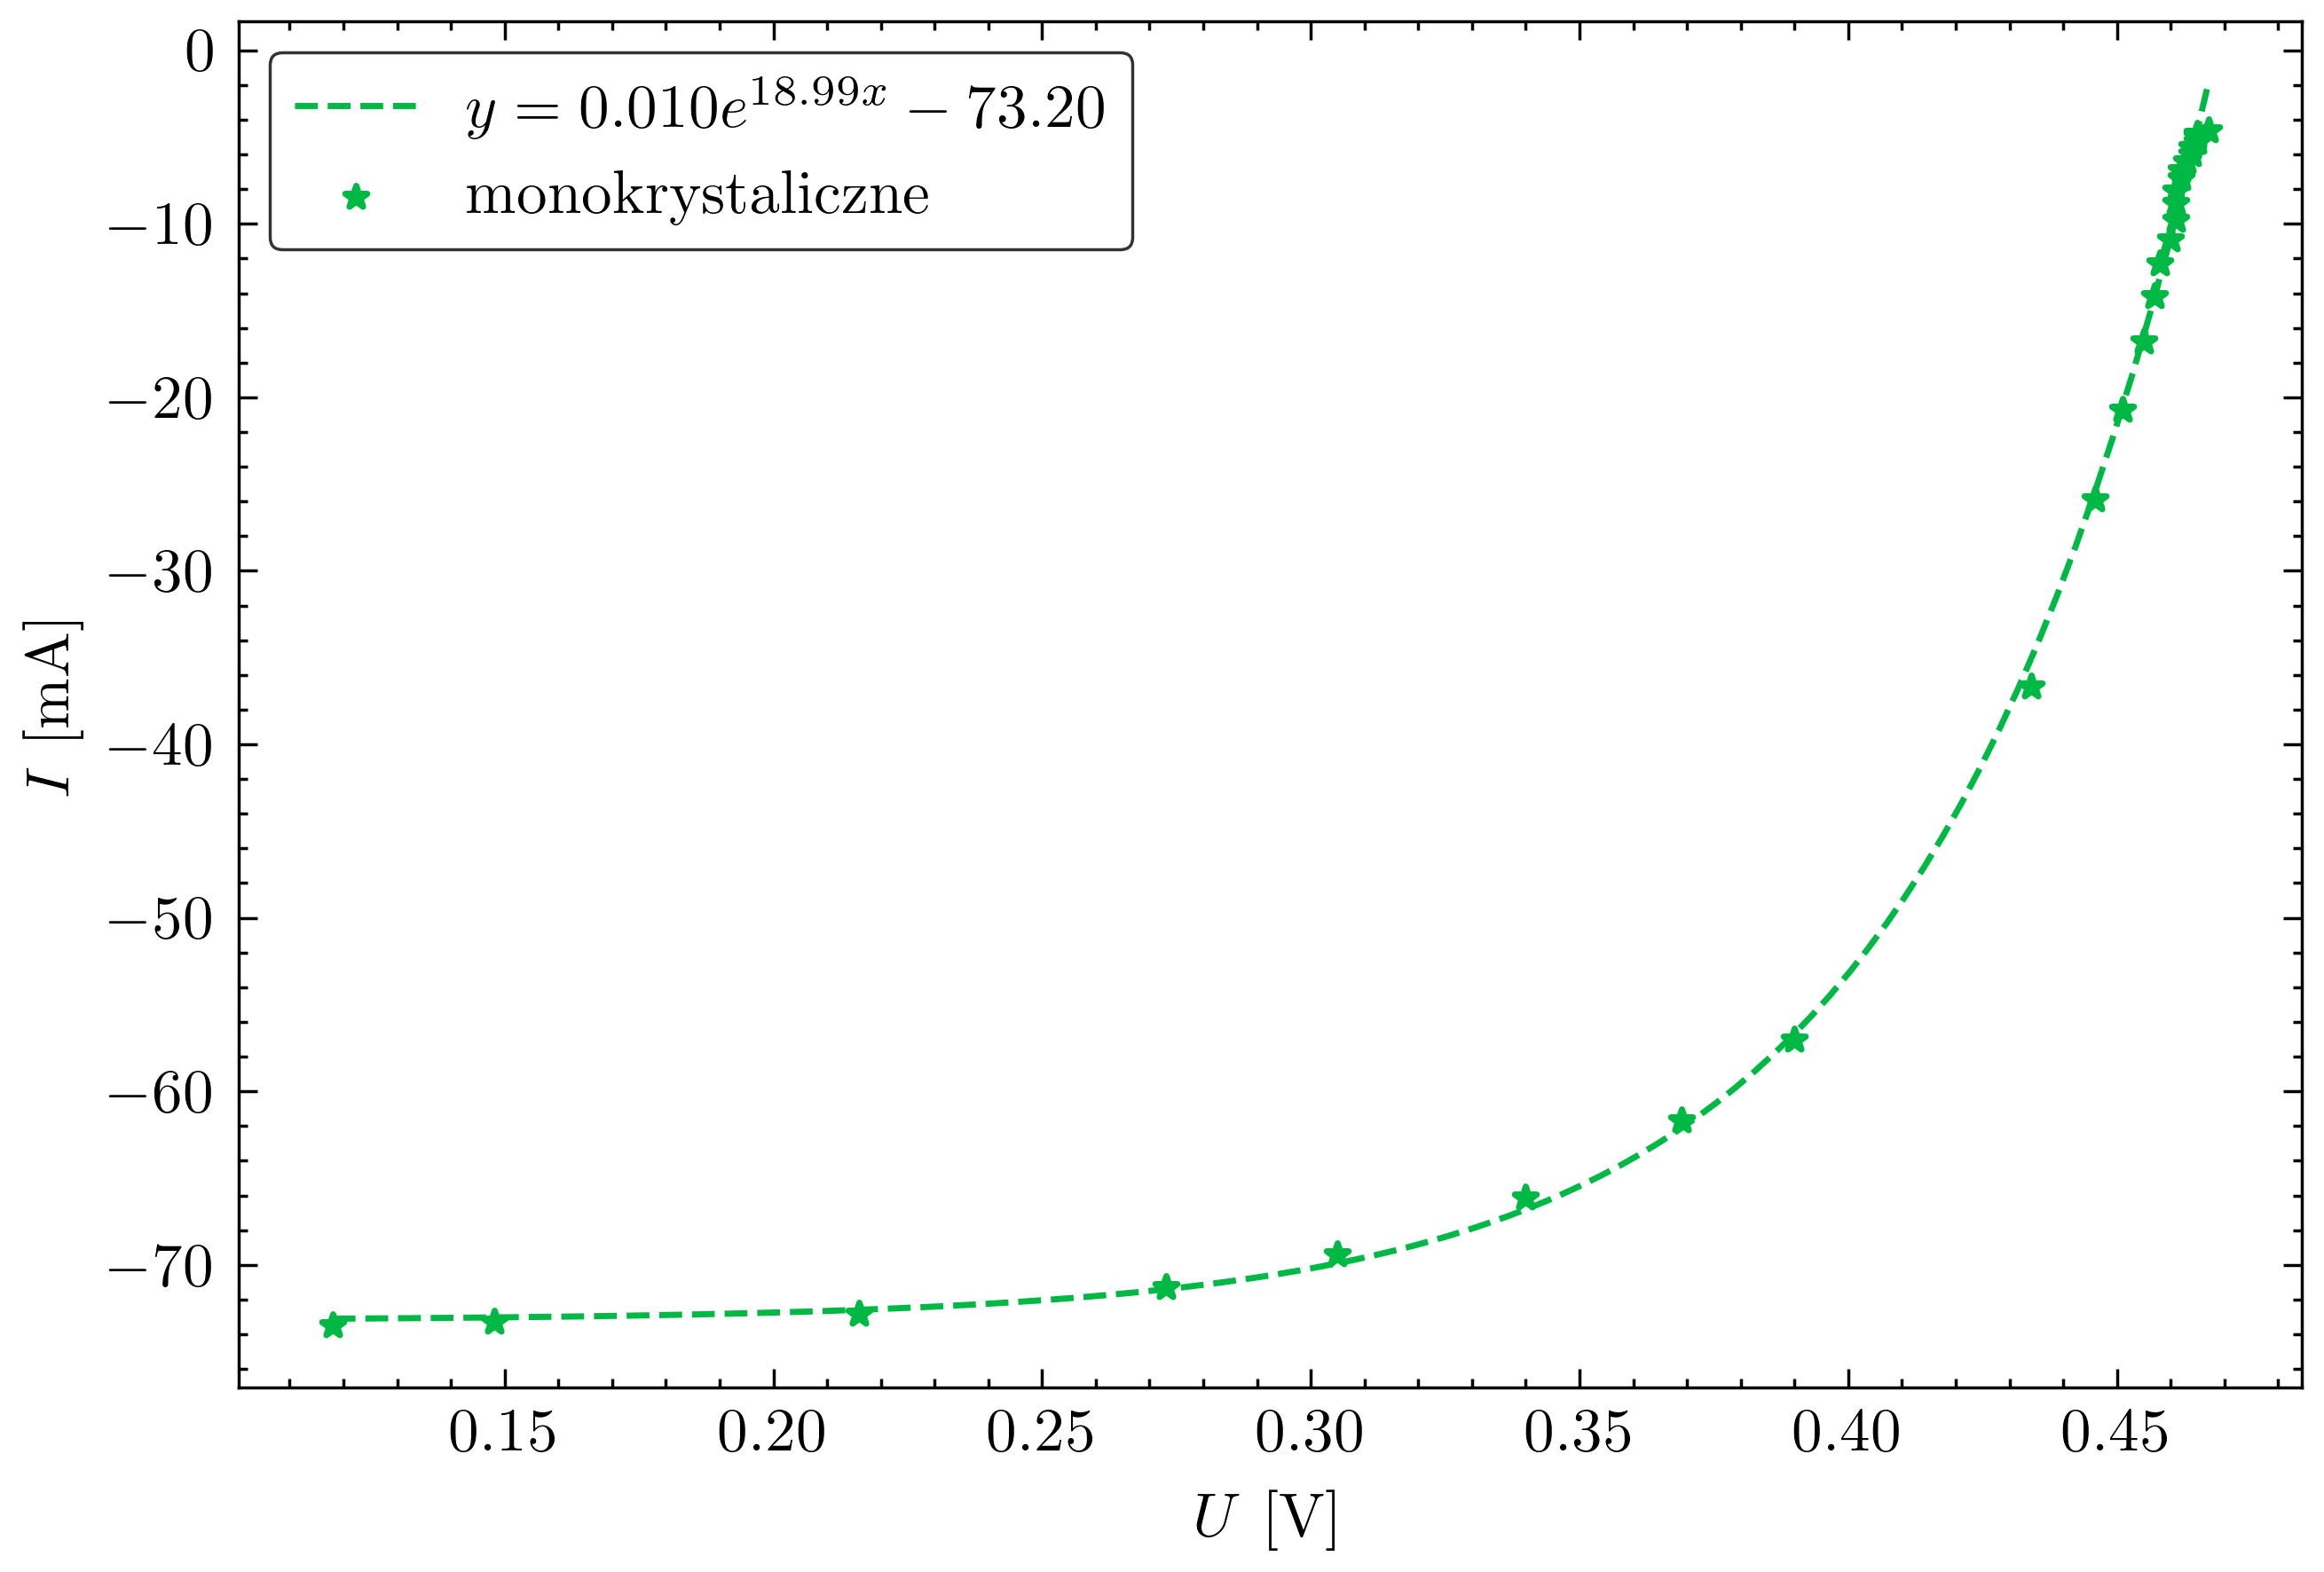

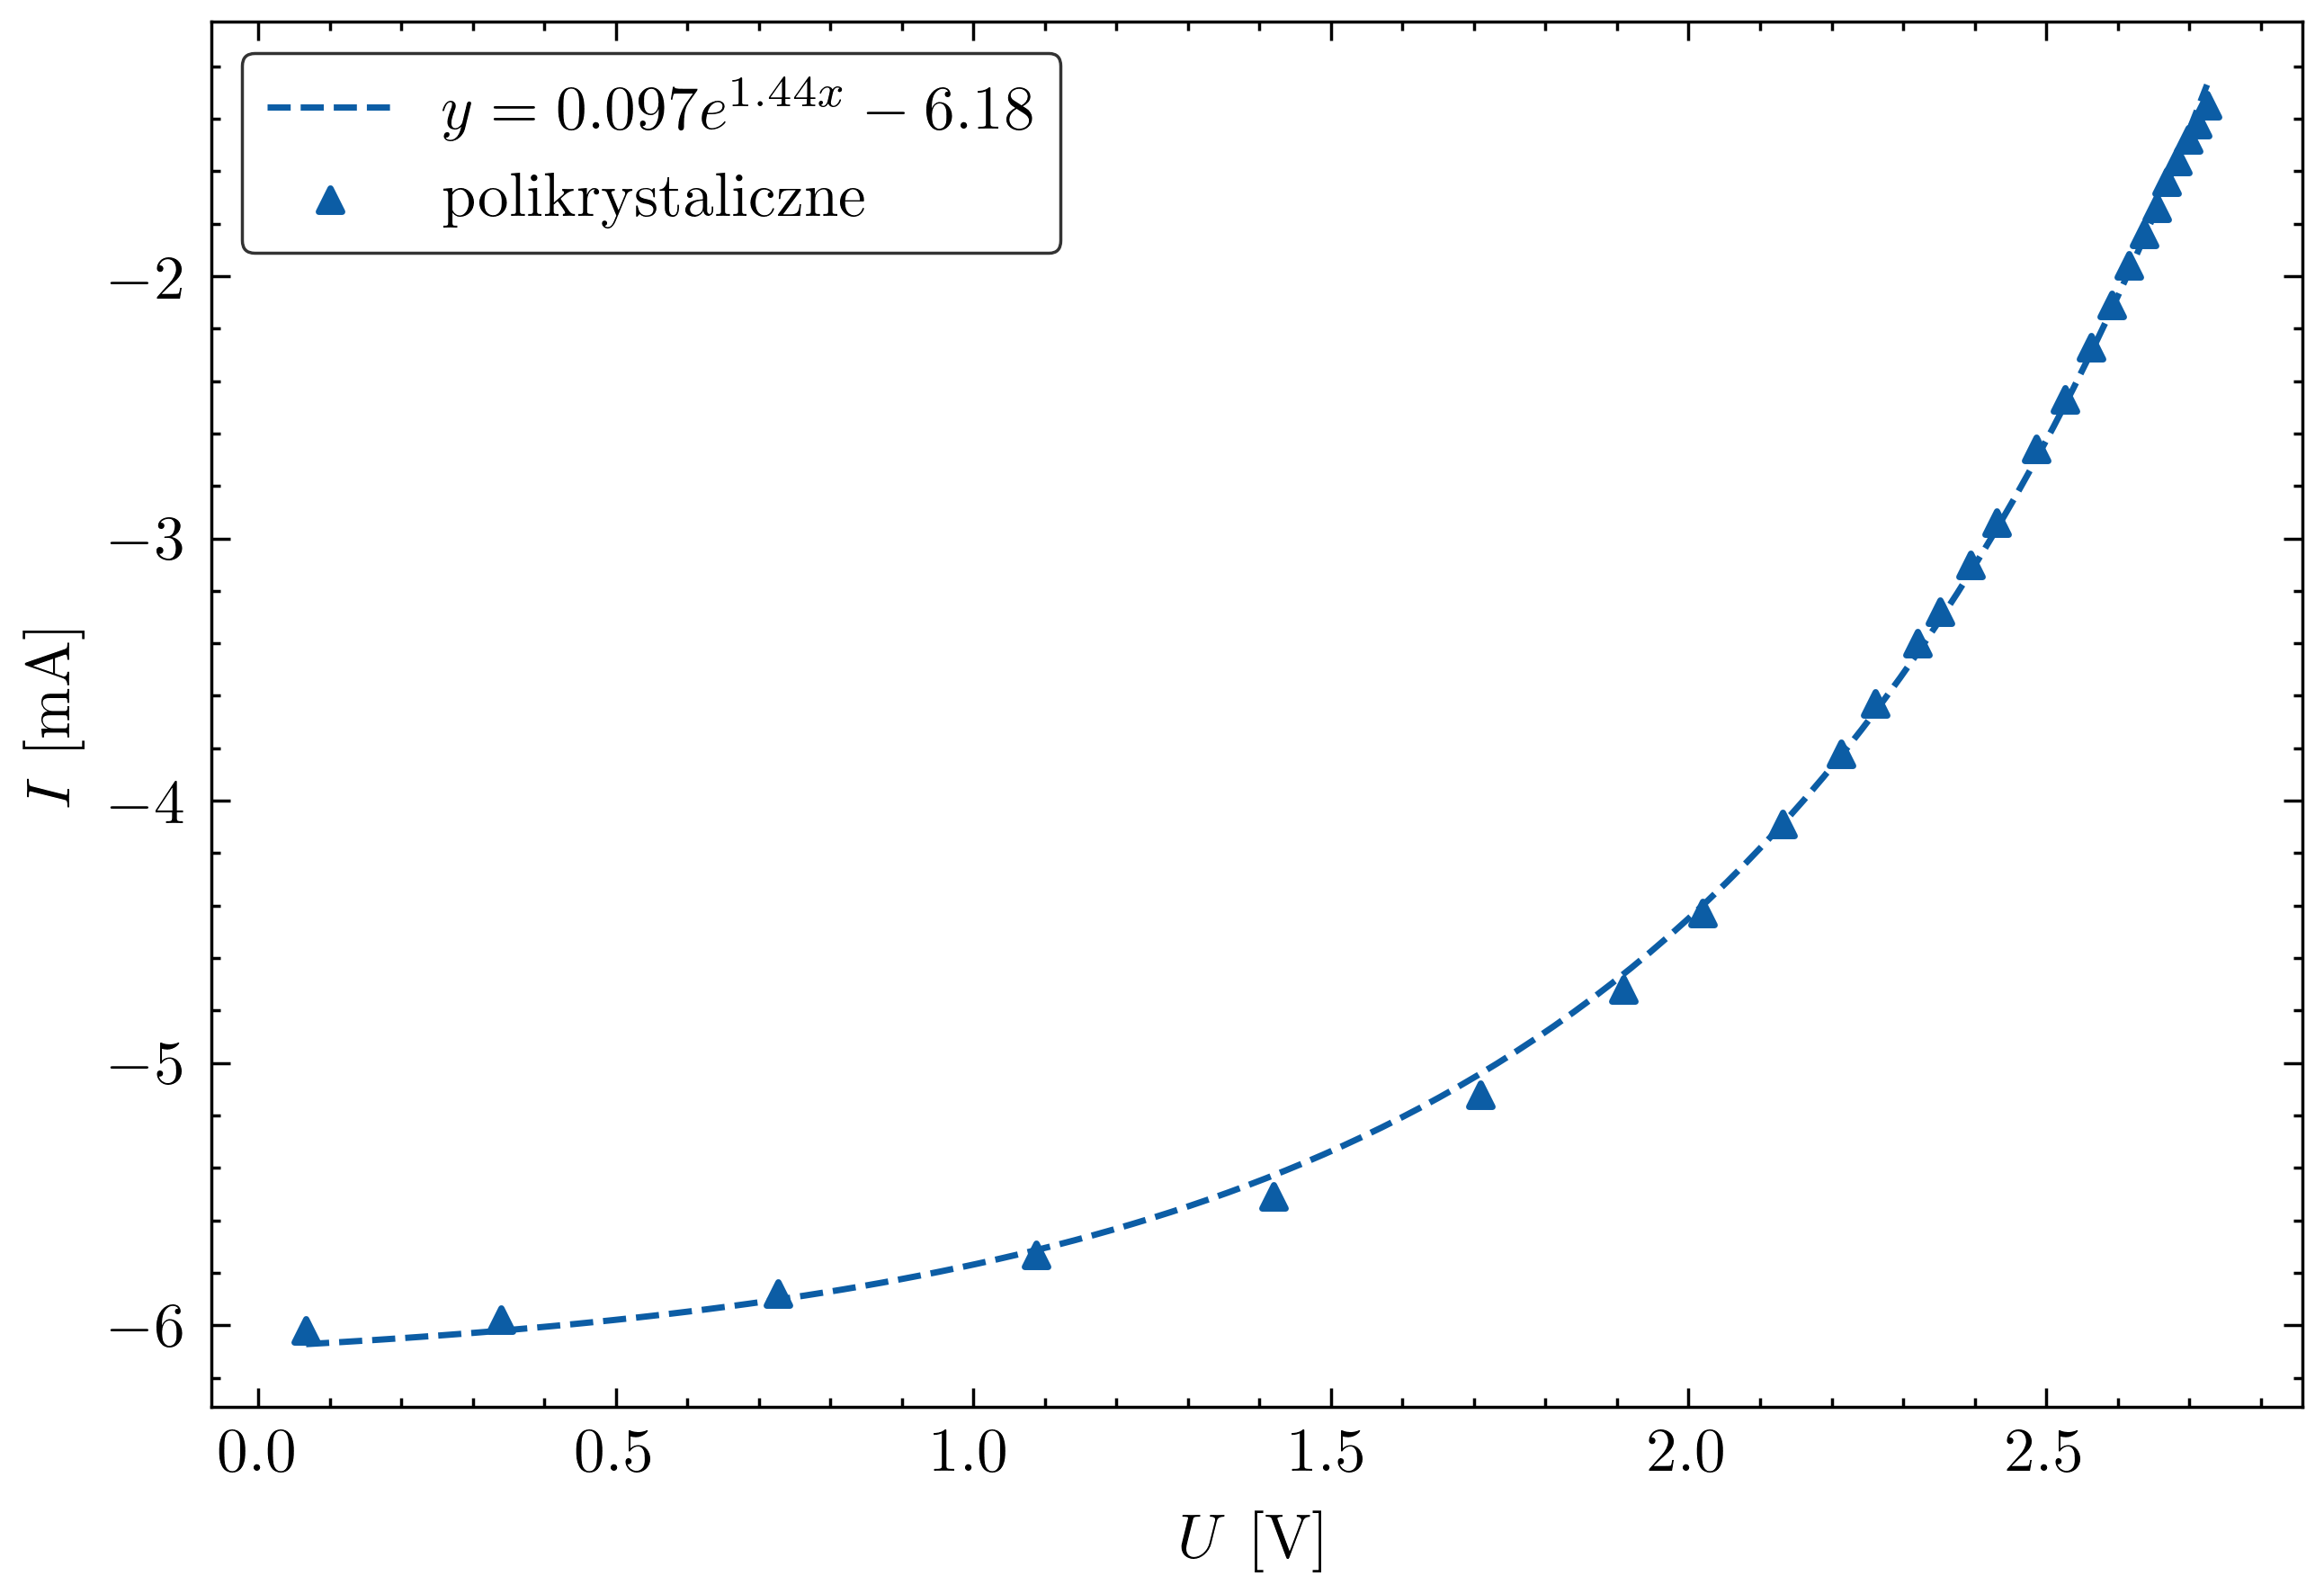

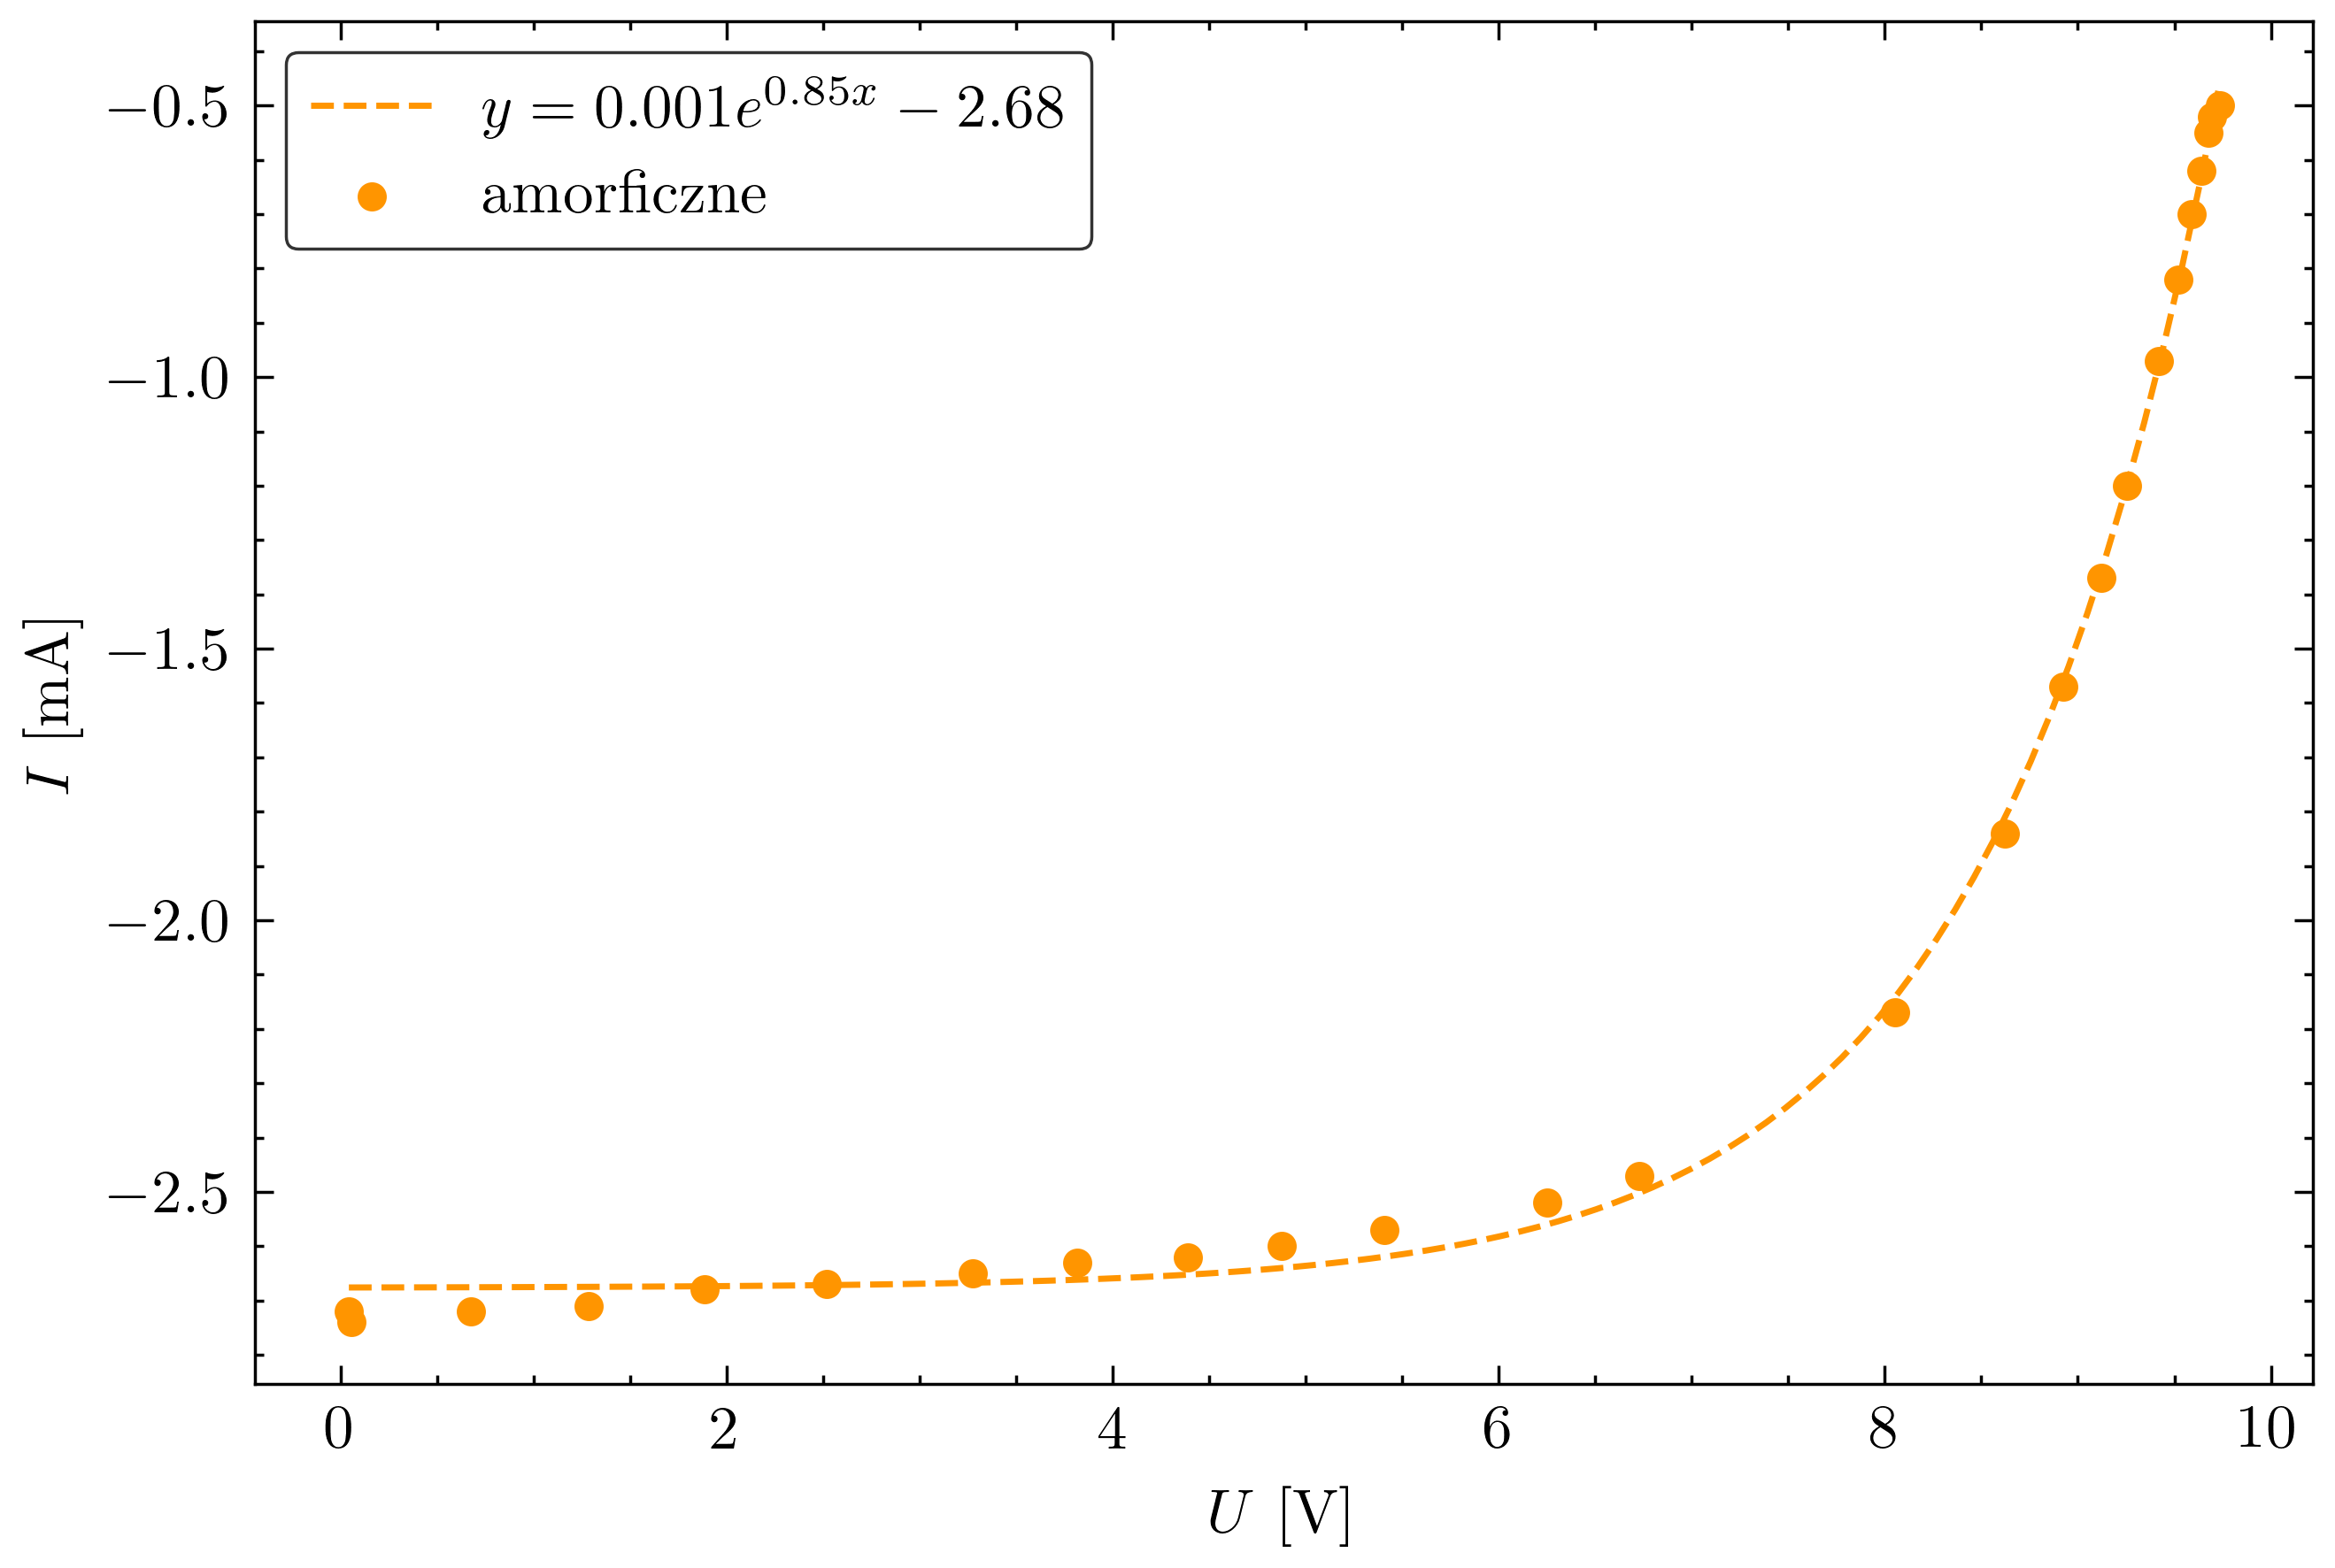

In [114]:

def draw_exp_graph(name, marker, color, label, method='lm', bounds=None):
    df = data[name].df
    print(name)
    
    if bounds is not None:
        popt, _ = curve_fit(fit_exp, df['U[V]'], df['I[mA]'], maxfev=5000,
                        method=method, 
                        bounds=bounds)
    else:
        popt, _ = curve_fit(fit_exp, df['U[V]'], df['I[mA]'], maxfev=5000, method=method)
    
    xdata = np.linspace(df['U[V]'].min(), df['U[V]'].max(), 100)

    fig, ax = plt.subplots(1, 1, figsize=(6,4),dpi = 500)
    ax.plot(xdata, fit_exp(xdata, *popt), linestyle='--', color=color, 
            label=rf'$y = {popt[0]:.3f}e^{{ {popt[1]:.2f} x  }} {popt[2]:+.2f}$')

    ax.scatter(x=df['U[V]'], y=df['I[mA]'], s=14, marker=marker, color=color, label=label)
    ax.set_xlabel(r"$U$ [V]")
    ax.set_ylabel(r"$I$ [mA]")
    legend = ax.legend(loc='upper left', frameon=True, edgecolor='black')
    legend.get_frame().set_linewidth(0.5)
    
    fig.savefig(f'images/{name}.png')


draw_exp_graph('mono', '*', 'C1', 'monokrystaliczne', 'trf', bounds=[(0, 0, -100), (2, 100,  100)])
draw_exp_graph('poli', '^', 'C0', 'polikrystaliczne')
draw_exp_graph('amorf', 'o', 'C2', 'amorficzne')



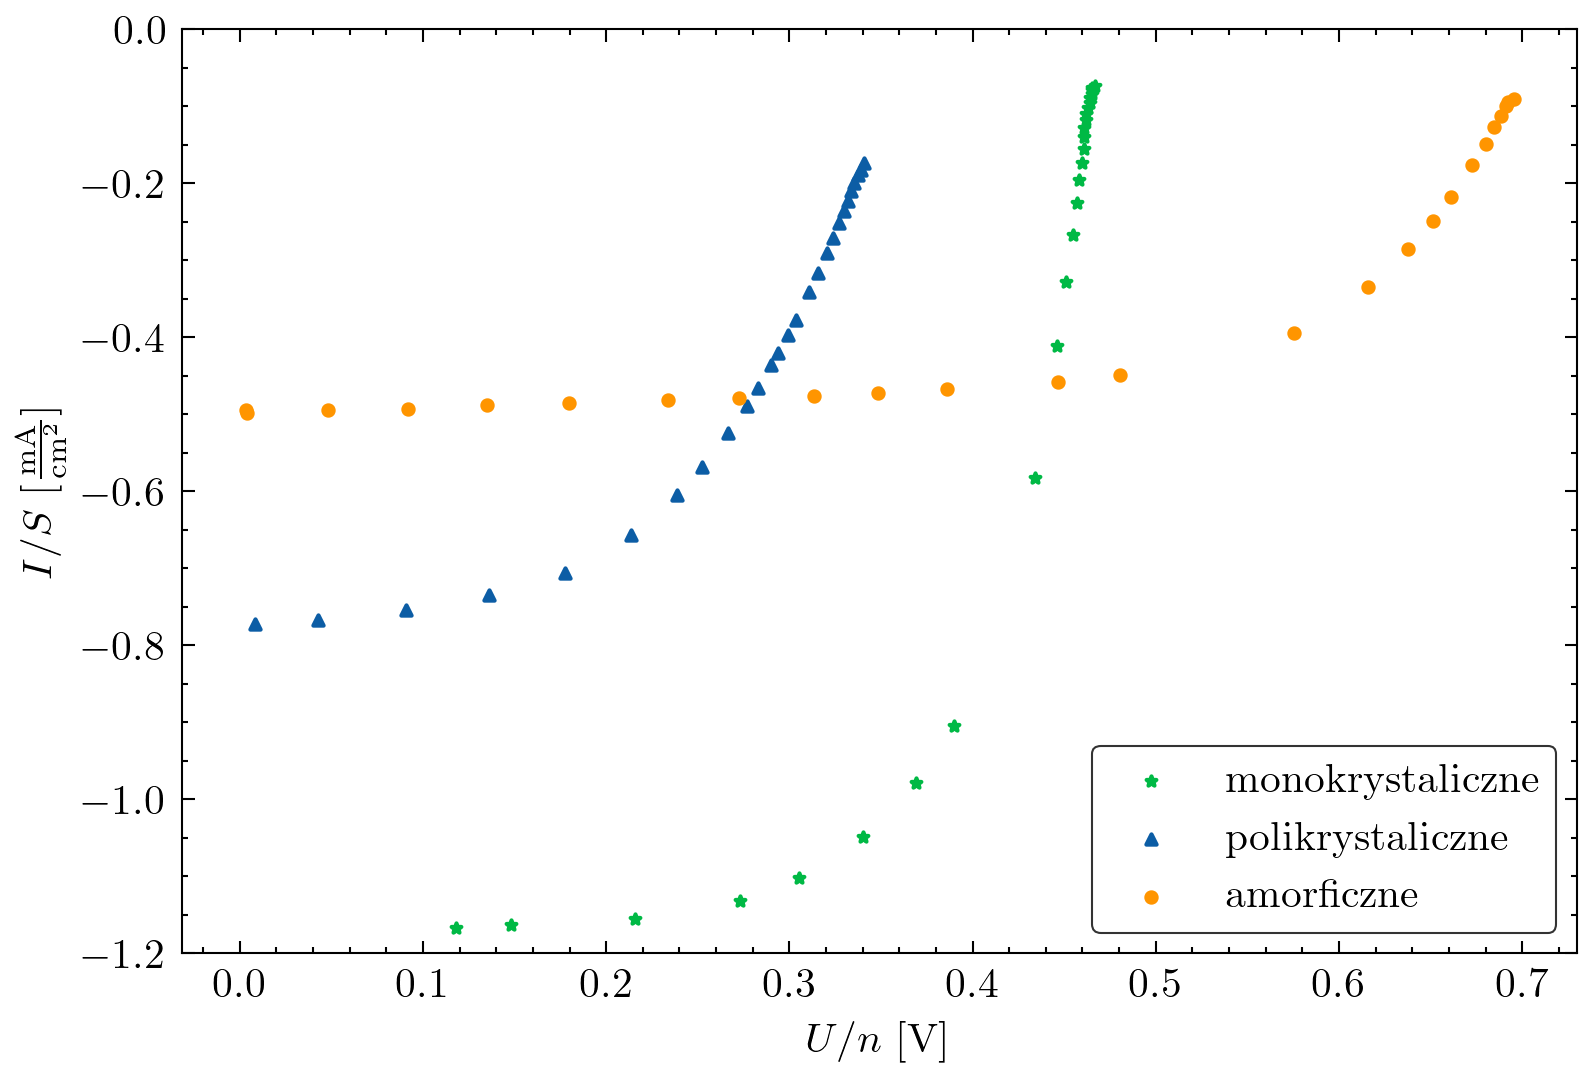

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(6,4),dpi = 300)

poli = data['poli'].df

mono = data['mono'].df
ax.scatter(x=mono['U/n[V]'], y=mono['j=I/s[mA/cm2]'],
           s=6, marker='*', label='monokrystaliczne', color='C1')

ax.scatter(x=poli['U/n[V]'], y=poli['j=I/s[mA/cm2]'],
           s=6, marker='^', label='polikrystaliczne', color='C0')

amorf = data['amorf'].df
ax.scatter(x=amorf['U/n[V]'], y=amorf['j=I/s[mA/cm2]'],
           s=6, marker='o', label='amorficzne', color='C2')

ax.set_xlabel(r"$U/n$ [V]")
ax.set_ylabel(r"$I/S$ [$\frac{\text{mA}}{\text{cm}^2}$]")
ax.set_ylim(-1.2, 0)

legend = ax.legend(loc='lower right', frameon=True, edgecolor='black')
legend.get_frame().set_linewidth(0.5)

fig.savefig('images/combined.png')


In [122]:
light_intensity = 56.3
uLightIntensity = 0.50
for name in data:
    df = data[name].df
    index = df['P[mW]'].idxmax()

    total_surface = data[name].total_surface
    pmax = df['P[mW]'][index]
    U =  df['U[V]'][index]
    I = df['I[mA]'][index]
    uU = data[name].uU
    uI = data[name].uI

    uP = np.sqrt ( (I*uU)**2 + (U*uI)**2)
    uEfficiency = np.sqrt(
        (10* uP / light_intensity / total_surface)**2 + 
        (10*pmax*uLightIntensity / light_intensity**2 / total_surface )**2
    )


    efficiency = df['P[mW]'].max() / total_surface / light_intensity * 10
    print (name, 'max power:' ,pmax , 'u(P) = ', uP,  'U =', U,'I =',  I, 
                 'efficiency[%]:', efficiency*100,
                 'uEfficiency[%]', uEfficiency*100
                 )


mono max power: 22.767 u(P) =  0.6181024267870172 U = 0.369 I = -61.7 efficiency[%]: 6.418844624883702 uEfficiency[%] 0.18335247320315248
poli max power: 9.01 u(P) =  0.060708750604834556 U = 1.909 I = -4.72 efficiency[%]: 2.5646718586327824 uEfficiency[%] 0.02859025617131254
amorf max power: 17.479 u(P) =  0.16255491379838383 U = 8.055 I = -2.17 efficiency[%]: 4.031971580817051 uEfficiency[%] 0.051848441478182496


In [117]:
df = data['mono'].df
i = df['P[mW]'].idxmax()
df['P[mW]'][i]
df['U[V]'][i]


0.369

In [118]:
df = data['amorf'].df
df['j=I/s[mA/cm2]'] *= -1

In [119]:
n_places = lambda places: lambda n : f'{n:.{places}f}'
formatters = {
    'U[V]': n_places(3),
    'I[mA]': n_places(2),
    'P[mW]' : n_places(3),
    'R[Ohm]' : n_places(3),
    'U/n[V]': n_places(3),
    'j=I/s[mA/cm2]': n_places(3)

}
print(df.to_latex(index=False, formatters=formatters,
        header=['$U$ [V]', '$I$ [mA]', '$P = U \cdot I$ [mW]', '$R$ [$\Omega$]', '$U/n$ [V]',  r'$j=I/S$ [mA/$\text{{cm}}^2$]' ]))

\begin{tabular}{rrrrrr}
\toprule
$U$ [V] & $I$ [mA] & $P = U \cdot I$ [mW] & $R$ [$\Omega$] & $U/n$ [V] & $j=I/S$ [mA/$\text{cm}^2$] \\
\midrule
9.735 & -0.50 & 4.868 & 19470.000 & 0.695 & 0.091 \\
9.695 & -0.52 & 5.041 & 18644.231 & 0.693 & 0.095 \\
9.678 & -0.55 & 5.323 & 17596.364 & 0.691 & 0.100 \\
9.638 & -0.62 & 5.976 & 15545.161 & 0.688 & 0.113 \\
9.588 & -0.70 & 6.712 & 13697.143 & 0.685 & 0.127 \\
9.520 & -0.82 & 7.806 & 11609.756 & 0.680 & 0.149 \\
9.420 & -0.97 & 9.137 & 9711.340 & 0.673 & 0.176 \\
9.255 & -1.20 & 11.106 & 7712.500 & 0.661 & 0.218 \\
9.120 & -1.37 & 12.494 & 6656.934 & 0.651 & 0.249 \\
8.926 & -1.57 & 14.014 & 5685.350 & 0.638 & 0.285 \\
8.623 & -1.84 & 15.866 & 4686.413 & 0.616 & 0.335 \\
8.055 & -2.17 & 17.479 & 3711.982 & 0.575 & 0.395 \\
6.728 & -2.47 & 16.618 & 2723.887 & 0.481 & 0.449 \\
6.250 & -2.52 & 15.750 & 2480.159 & 0.446 & 0.458 \\
5.407 & -2.57 & 13.896 & 2103.891 & 0.386 & 0.467 \\
4.877 & -2.60 & 12.680 & 1875.769 & 0.348 & 0.473 \\
4.389 & 